In [1]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable,AdvectionRK4
import matplotlib.pyplot as plt

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')

from OP_functions import *
from OP_Kernels import *

In [2]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)


In [3]:
# Define paths
paths = path(0)
#Load configuration from .yaml
start = datetime(2025, 8, 23) #Start date
length = 1 # Set Time length [days] 
dt = 5 #toggle between - or + to pick backwards or forwards 
N0 = 1 # number of deploying locations
n = 100 # 1000   # number of particles per location
dmin = 0.5 #minimum depth
name = 'test_dt_StokesDrift_'
dtp = 0
dd = 0 #depth difference in the cloud
odt = 1 #mins
rrr = 1e4


In [4]:
def p_deploy(N,n,dmin,dd,r = 1000):
    #r is radius of particle cloud [m]
    deg2m = 111000 * np.cos(50 * np.pi / 180)
    var = (r / (deg2m * 3))**2
    x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
    if isinstance(dmin,float):
        zvals1 = dmin + np.random.random_sample([n,N]).T*(dd)
    else:
        zvals = []
        zvals1 = []
        for dept in dmin:
            zvals.append(dept + np.random.random_sample([n]).T*(dd))
        for i in range(len(zvals)):   
            zvals1=np.concatenate((zvals1[:],zvals[i]))
    return x_offset, y_offset, zvals1

In [5]:
#Set deploy coordinates in the middle of SoG

clat = [49.23035]
clon = [-123.54752]

duration = timedelta(days=length)
x_offset, y_offset, z = p_deploy(N0,n,dmin,dd,rrr)

lon = np.zeros([N0,n])
lat = np.zeros([N0,n])
for i in range(N0):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [6]:
#Set start date time and the name of the output file

daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n_dt_FE'+str(dt)+'s' for d in [start, start+duration])
outfile = os.path.join(paths['out'], fn)
outfile

'/home/jvalenti/MOAD/results/test_dt_StokesDrift_20250823_1n_dt_FE5s_20250824_1n_dt_FE5s'

In [7]:
####BUILD FIELDS FOR SIMULATION######
local = 0 #meaning working on Salish computer 
#Fill in the list of variables that you want to use as fields
varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist,local)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

#Find file names and variable names
varlist=['US','VS','WL','Diat','Flag','R','T','S','FS','ssh','Bathy','Kz']
filenames,variables=filename_set(start,length,varlist,local)

#Add Stokes Drift fields
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
us = Field.from_netcdf(filenames['US'], variables['US'], dimensions,allow_time_extrapolation=True)
vs = Field.from_netcdf(filenames['VS'], variables['VS'], dimensions,allow_time_extrapolation=True)
wl = Field.from_netcdf(filenames['WL'], variables['WL'], dimensions,allow_time_extrapolation=True)
field_set.add_field(us)
field_set.add_field(vs)
field_set.add_field(wl)
field_set.add_vector_field(VectorField("stokes", us, vs, wl))

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    status = Variable('status', initial = 0) 
    us = Variable('us', initial =  0) 
    vs = Variable('vs', initial =  0) 
    cellvol = Variable('cellvol', initial =  0) # MF per parcel
    dlat = Variable('dlat', initial =  0) 
    dlon = Variable('dlon', initial =  0) 
    ddepth = Variable('ddepth', initial =  0) 

In [8]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt)) 

In [9]:
def Stokes_drift(particle, fieldset, time):
    #SOME CONSTANTS NEEDED LATER 
    deg2met = 111319.5
    latT = 0.6495 #Average value for SoG #cos(particle.lat*(math.pi/180))
    """Apply Stokes drift calculated by WW3"""    
    (us0, vs0, wl) = fieldset.stokes[time, 0, particle.lat, particle.lon]
    k = (2*math.pi)/wl
    us = (us0*exp(-math.fabs(2*k*particle.depth)))/(deg2met*latT)
    vs = (vs0*exp(-math.fabs(2*k*particle.depth)))/deg2met
    particle.us = us* particle.dt
    particle.vs = vs* particle.dt
    particle_dlon += us * particle.dt
    particle_dlat += vs * particle.dt

In [10]:
def Stokes_driftRK4(particle, fieldset, time):
    #SOME CONSTANTS NEEDED LATER 
    deg2met = 111319.5
    latT = 0.6495 #Average value for SoG #cos(particle.lat*(math.pi/180))
    """Apply Stokes drift calculated by WW3"""    
    (us0, vs0, wl) = fieldset.stokes[time, 0, particle.lat, particle.lon]
    k = (2*math.pi)/wl
    us1 = (us0*exp(-math.fabs(2*k*particle.depth)))/(deg2met*latT)
    vs1 = (vs0*exp(-math.fabs(2*k*particle.depth)))/deg2met
    lon1 = particle.lon + us1*.5*particle.dt
    lat1 = particle.lat + vs1*.5*particle.dt
    (us0, vs0, wl) = fieldset.stokes[time+ .5 * particle.dt, 0, lat1, lon1]
    us2= (us0*exp(-math.fabs(2*k*particle.depth)))/(deg2met*latT)
    vs2 = (vs0*exp(-math.fabs(2*k*particle.depth)))/deg2met
    lon2 = particle.lon + us2*.5*particle.dt
    lat2 = particle.lat + vs2*.5*particle.dt
    (us0, vs0, wl) = fieldset.stokes[time+ .5 * particle.dt, 0, lat2, lon2]
    us3= (us0*exp(-math.fabs(2*k*particle.depth)))/(deg2met*latT)
    vs3 = (vs0*exp(-math.fabs(2*k*particle.depth)))/deg2met
    lon3 = particle.lon + us3*particle.dt
    lat3 = particle.lat + vs3*particle.dt
    (us0, vs0, wl) = fieldset.stokes[time+particle.dt, 0, lat3, lon3]
    us4= (us0*exp(-math.fabs(2*k*particle.depth)))/(deg2met*latT)
    vs4 = (vs0*exp(-math.fabs(2*k*particle.depth)))/deg2met
    
    us = (us1 + 2*us2 + 2*us3 + us4) / 6.
    vs = (vs1 + 2*vs2 + 2*vs3 + vs4) / 6.

    particle.us = us* particle.dt
    particle.vs = vs* particle.dt
    particle_dlon += us * particle.dt
    particle_dlat += vs * particle.dt

In [11]:
pset.execute([AdvectionRK4,Stokes_drift],
                runtime=duration, 
                dt=dt,
                output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)),
                )

INFO: Output files are stored in /home/jvalenti/MOAD/results/test_dt_StokesDrift_20250823_1n_dt_FE5s_20250824_1n_dt_FE5s.zarr.
100%|██████████| 86400.0/86400.0 [01:05<00:00, 1328.95it/s]


In [12]:
#Set start date time and the name of the output file

daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n_dt_RK4'+str(dt)+'s' for d in [start, start+duration])
outfile = os.path.join(paths['out'], fn)
outfile

'/home/jvalenti/MOAD/results/test_dt_StokesDrift_20250823_1n_dt_RK45s_20250824_1n_dt_RK45s'

In [13]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt)) 
pset.execute([AdvectionRK4,Stokes_driftRK4],
                runtime=duration, 
                dt=dt,
                output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)),
                )

INFO: Output files are stored in /home/jvalenti/MOAD/results/test_dt_StokesDrift_20250823_1n_dt_RK45s_20250824_1n_dt_RK45s.zarr.
100%|██████████| 86400.0/86400.0 [01:05<00:00, 1322.75it/s]


In [14]:
dt5 =xr.open_zarr('/home/jvalenti/MOAD/results/test_dt_StokesDrift_20250823_1n_dt_FE5s_20250824_1n_dt_FE5s.zarr')
dtRK4 =xr.open_zarr('/home/jvalenti/MOAD/results/test_dt_StokesDrift_20250823_1n_dt_RK45s_20250824_1n_dt_RK45s.zarr')

8.844558e-12 -1.2167793e-12


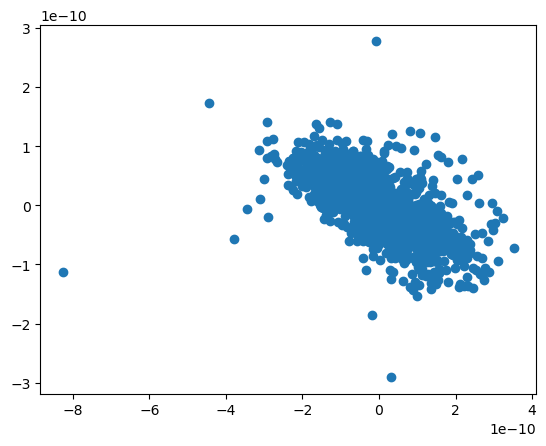

In [15]:
import matplotlib.pyplot as plt
udiff = np.array(dtRK4.us).flatten()-np.array(dt5.us).flatten()
vdiff = np.array(dtRK4.vs).flatten()-np.array(dt5.vs).flatten()
plt.scatter(udiff,vdiff)
print(np.mean(udiff),np.mean(vdiff))